<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula2d_custo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [283]:
import numpy as np

def criaDataset(n=20, slop=[2,1], intercept=0, dummy_features=0):
  X = np.random.uniform(size=(n,dummy_features+2))
  AUX = np.multiply(X[:,:2], slop)-[0, intercept]
  y = np.array(AUX[:,0]>AUX[:,1], dtype=int)*2-1
  return X, y

slop=[-1,2]
intercept = 1
X, y = criaDataset(slop=slop, intercept=intercept)
X, y

(array([[0.50988655, 0.7207556 ],
        [0.30373925, 0.6897859 ],
        [0.80389522, 0.02478202],
        [0.73747676, 0.54073681],
        [0.58118902, 0.37089032],
        [0.89251683, 0.12381547],
        [0.07662875, 0.68914518],
        [0.67253342, 0.42323379],
        [0.20320356, 0.07631715],
        [0.08242698, 0.22592915],
        [0.51453162, 0.50812006],
        [0.96982045, 0.74648254],
        [0.87955216, 0.70397259],
        [0.58852648, 0.31294483],
        [0.41145709, 0.37022891],
        [0.42236855, 0.09120825],
        [0.42264479, 0.59885263],
        [0.57816217, 0.80643493],
        [0.60321351, 0.0152431 ],
        [0.3026608 , 0.8049072 ]]),
 array([-1, -1,  1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1,  1, -1,
        -1,  1, -1]))

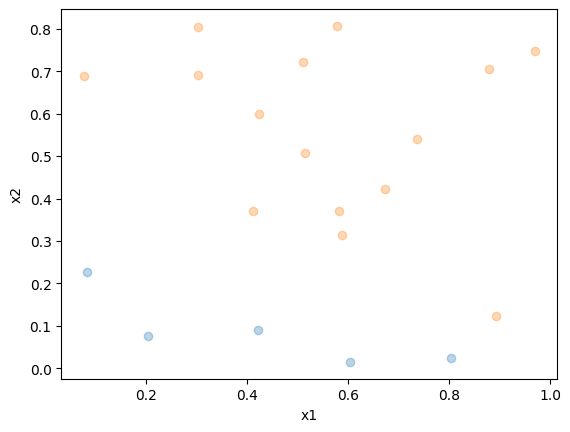

In [284]:
import matplotlib.pyplot as plt

def plotDataset(X, y):
  plt.xlabel('x1')
  plt.ylabel('x2')
  for k in set(y):
    plt.plot(X[:,0][y==k],X[:,1][y==k], 'o', alpha=0.3)

plotDataset(X, y)

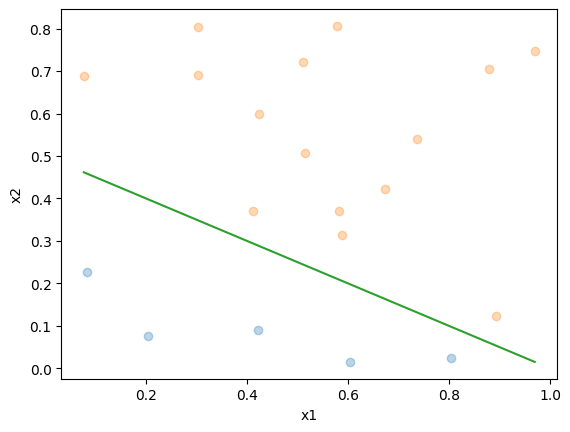

In [285]:
def plotHiperplano(X, y, vetor, intercept=0):
  x0min = min(X[:,0])
  x0max = max(X[:,0])
  xs = np.linspace(x0min, x0max, num=2)
  ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
  plt.plot(xs, ys)

plotDataset(X, y)
vetor_hiperplano = np.array(slop) * np.array([1, -1])
plotHiperplano(X, y, vetor_hiperplano, intercept)

In [286]:
def sign(a):
  return (a >= 0) * 2 -1

In [287]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
  @abstractstaticmethod
  def custo(y, ypred):
    pass
  @abstractstaticmethod
  def gradiente(y, ypred, X):
    pass

class WidrowHoff(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum((y-ypred)**2)
  @staticmethod
  def gradiente(y, ypred, X):
    return X.T @ (y - ypred)

class SmoothSurrogate(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), -y * ypred))
  @staticmethod
  def gradiente(y, ypred, X):
    return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
  @staticmethod
  def custo(y, ypred):
    return  np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
  @staticmethod
  def gradiente(y, ypred, X):
    errosmarginais = (y * ypred) < 1
    ymarginais = np.copy(y)
    ymarginais[~errosmarginais] = 0
    return X.T @ ymarginais

In [288]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y, activation=None):
    pass

class DescidaGradiente(TrainingAlgorithm):
  def __init__(self, max_iter=500, learning_rate=0.01,
               regularization=0, cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=X.shape[1])
    for _ in range(self.max_iter):
      ypred = X @ w
      erros = y - ypred
      if self.cost.custo(y, ypred) == 0:
        break
      w *= 1 - self.regularization * self.learning_rate
      w += self.cost.gradiente(y, ypred, X) * self.learning_rate
    return w


In [289]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

def include_bias(X):
  bias = np.ones((X.shape[0],1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class Perceptron(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=DescidaGradiente()):
    self.w = None
    self.activation = sign
    self.training_algorithm = training_algorithm

  def fit(self, X, y):
    Xb = include_bias(X)
    self.w = self.training_algorithm.getW(Xb, y)

  def __pre_activation(self, X):
    Xb = include_bias(X)
    return Xb @ self.w

  def predict(self, X):
    a = self.__pre_activation(X)
    ypred = self.activation(a)
    return ypred


1.0
[ 1.03303437 -0.85718525 -2.44573479]
0.98


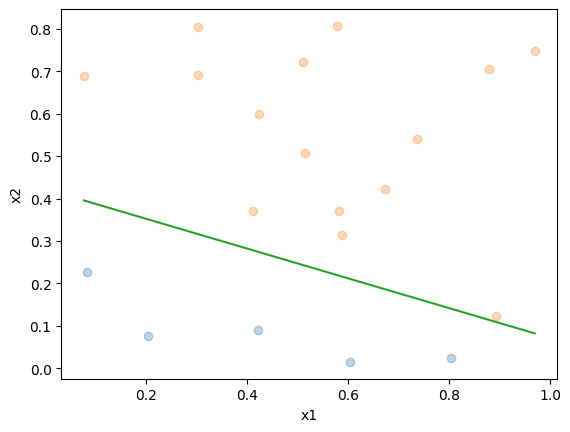

1.0
[ 1.02852917 -0.8521274  -2.44202875]
0.98


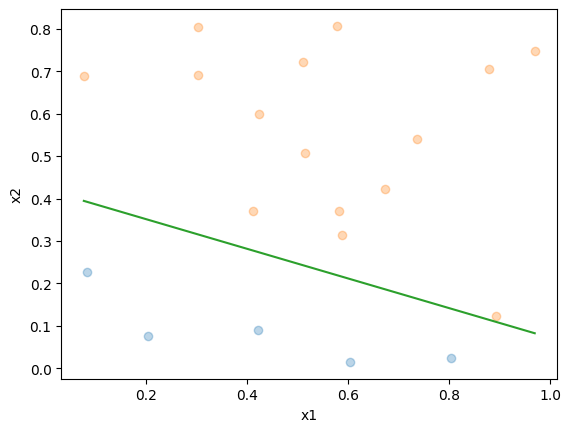

1.0
[ 0.12375184 -0.07099863 -0.50579885]
0.915


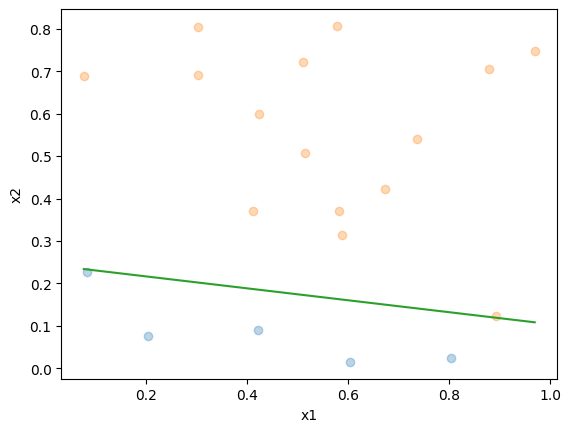

1.0
[ 0.11106966 -0.09692324 -0.2003314 ]
0.94


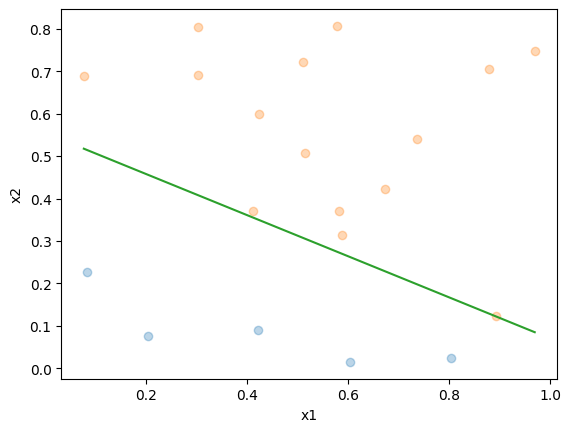

1.0
[ 1.9272035  -2.15193875 -4.509696  ]
0.93


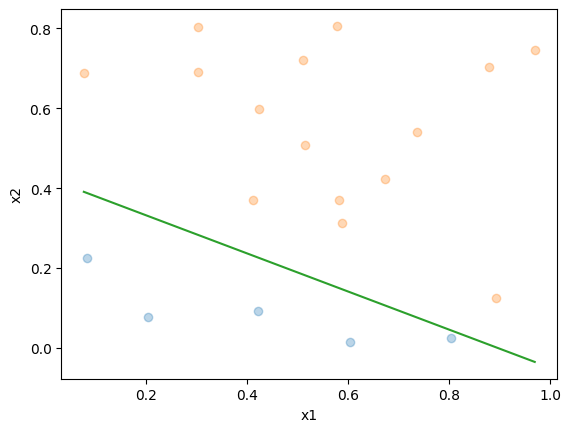

1.0
[ 2.43508299 -2.51284045 -5.41195691]
0.975


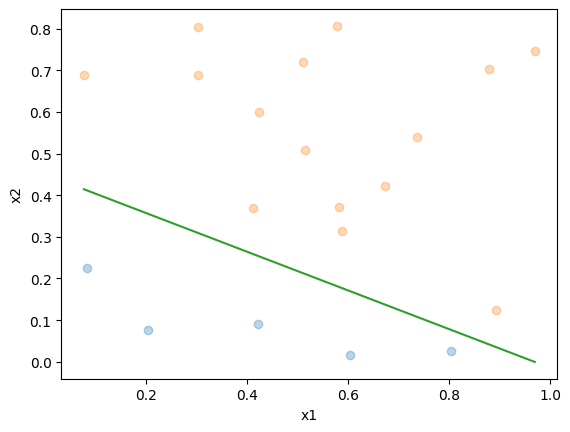

In [296]:
costs = [WidrowHoff(), SmoothSurrogate(), HingeLoss()]
Xte, yte = criaDataset(200, slop, intercept)
for cost in costs:
  for _ in range(2):
    perceptron = Perceptron(training_algorithm=DescidaGradiente(cost=cost))
    perceptron.fit(X, y)
    ypred = perceptron.predict(X)
    print(accuracy_score(y, ypred))
    print(perceptron.w)
    plotDataset(X, y)
    # plotDataset(X, ypred)
    plotHiperplano(X, y, perceptron.w[1:], perceptron.w[0])
    ypred = perceptron.predict(Xte)
    print(accuracy_score(yte, ypred))
    # print(perceptron.w)
    plt.show()
    # plotDataset(Xte, yte)
    # # plotDataset(X, ypred)
    # plotHiperplano(Xte, yte, perceptron.w[1:], perceptron.w[0])
    # plt.show()